In [2]:
from lmfit import Parameters
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
from core.util.units import compute_dft

In [3]:
def sine_testing():
    """ Sinus fit testing with a self defined estimator. """

    x_axis = np.linspace(0, 25, 75)
    x_axis1 = np.linspace(25, 50, 75)
    x_axis = np.append(x_axis, x_axis1)
    x_nice = np.linspace(x_axis[0],x_axis[-1], 1000)

    mod,params = fitlogic.make_sine_model()
    print('Parameters of the model',mod.param_names,
          ' with the independet variable',mod.independent_vars)

    print(1/(x_axis[1]-x_axis[0]))
    params['amplitude'].value=0.9 + np.random.normal(0,0.4)
    params['frequency'].value=0.1
    params['phase'].value=np.pi*1.0
    params['offset'].value=3.94+np.random.normal(0,0.4)

    data_noisy=(mod.eval(x=x_axis,params=params) + 0.3*np.random.normal(size=x_axis.shape))


    # set the offset as the average of the data
    offset = np.average(data_noisy)

    # level data
    data_level = data_noisy - offset

    # estimate amplitude
    ampl_val = max(np.abs(data_level.min()), np.abs(data_level.max()))

    # calculate dft with zeropadding to obtain nicer interpolation between the
    # appearing peaks.
    dft_x, dft_y = compute_dft(x_axis, data_level, zeropad_num=1)

    plt.figure()
    plt.plot(dft_x, dft_y, label='dft of data')
    plt.xlabel('Frequency')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    stepsize = x_axis[1]-x_axis[0]  # for frequency axis
    frequency_max = np.abs(dft_x[np.log(dft_y).argmax()])

    print(frequency_max)
    print('offset',offset)
#
    # find minimal distance to the next meas point in the corresponding time
    # value
    diff_array = np.ediff1d(x_axis)
    min_x_diff = diff_array.min()

    # if at least two identical values are in the array, then the difference is
    # of course zero, catch that case.
    for tries in range(len(diff_array)):
        if np.isclose(min_x_diff, 0.0):
            index = np.argmin(diff_array)
            diff_array = np.delete(diff_array, index)
            min_x_diff = diff_array.min()

        else:
            if len(diff_array) == 0:
                fitlogic.log.error('The passed x_axis for the sinus estimation contains the same values!'
                                   ' Cannot do the fit!')

                return -1, params
            else:
                min_x_diff = diff_array.min()
            break

    # How many points are used to sample the estimated frequency with min_x_diff:
    iter_steps = int(1/(frequency_max*min_x_diff))
    if iter_steps < 1:
        iter_steps = 1

    sum_res = np.zeros(iter_steps)

    # Procedure: Create sin waves with different phases and perform a summation.
    #            The sum shows how well the sine was fitting to the actual data.
    #            The best fitting sine should be a maximum of the summed time
    #            trace.

    for iter_s in range(iter_steps):
        func_val = ampl_val * np.sin(2*np.pi*frequency_max*x_axis + iter_s/iter_steps *2*np.pi)
        sum_res[iter_s] = np.abs(data_level - func_val).sum()

    plt.figure()
    plt.plot(list(range(iter_steps)), sum_res, label='sum of different phase iteration')
    plt.xlabel('iteration')
    plt.ylabel('summed value')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    # The minimum indicates where the sine function was fitting the worst,
    # therefore subtract pi. This will also ensure that the estimated phase will
    # be in the interval [-pi,pi].
    phase = sum_res.argmax()/iter_steps *2*np.pi - np.pi

    mod, params = fitlogic.make_sine_model()

    # values and bounds of initial parameters
    params['amplitude'].set(value=ampl_val)
    params['frequency'].set(value=frequency_max, min=0.0, max=1/(stepsize)*3)
    params['phase'].set(value=phase, min=-np.pi, max=np.pi)
    params['offset'].set(value=offset)

    # perform fit:
    result = mod.fit(data_noisy, x=x_axis, params=params)

    plt.plot(x_axis,data_noisy,'ob', label='noisy data')
    plt.plot(x_axis,result.init_fit,'-y', label='initial values')
    plt.plot(x_axis,result.best_fit,'-r',linewidth=2.0, label='actual fit')
    plt.xlabel('time')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

    plt.show()

Parameters of the model ['amplitude', 'frequency', 'phase', 'offset']  with the independet variable x
2.96
0.0986666666666
offset 4.01809182039


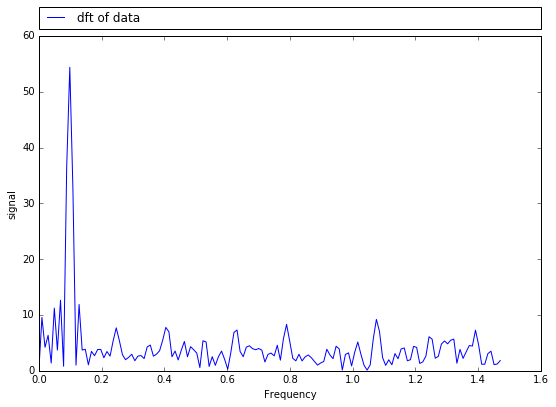

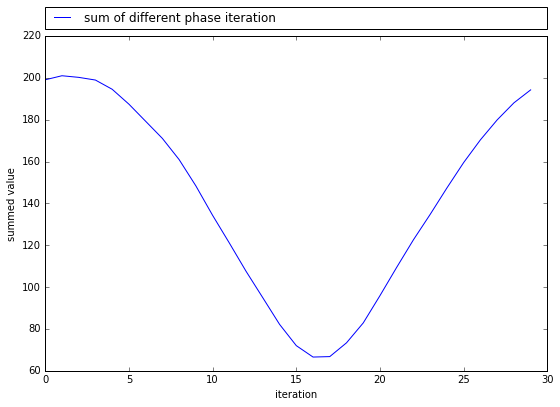

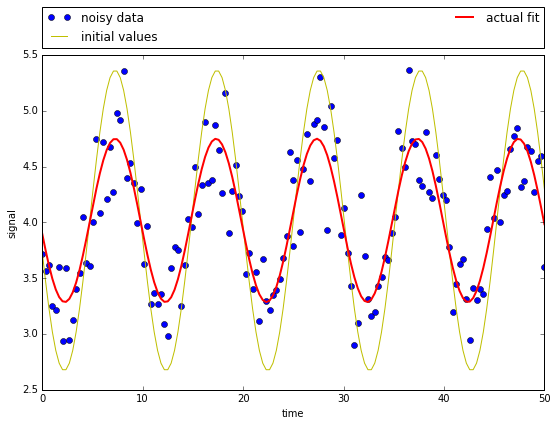

In [4]:
sine_testing()

In [5]:
def sine_testing2():
    """ Sinus fit testing with the direct fit method. """

    x_axis = np.linspace(0, 250, 75)
    x_axis1 = np.linspace(250, 500, 75)
    x_axis = np.append(x_axis, x_axis1)
    x_nice = np.linspace(x_axis[0],x_axis[-1], 1000)

    mod, params = fitlogic.make_sine_model()

    params['phase'].value = np.pi/2 # np.random.uniform()*2*np.pi
    params['frequency'].value = 0.01
    params['amplitude'].value = 1.5
    params['offset'].value = 0.4

    data = mod.eval(x=x_axis, params=params)
    data_noisy = (mod.eval(x=x_axis, params=params) + 1.5 * np.random.normal(size=x_axis.shape))

    update_dict = {}
    update_dict['phase'] = {'vary': False, 'value': np.pi/2.}

    result = fitlogic.make_sine_fit(
        x_axis=x_axis,
        data=data_noisy,
        add_params=update_dict,
        estimator=fitlogic.estimate_sine)

    plt.figure()
    plt.plot(x_axis, data_noisy, label='noisy data')
    plt.plot(x_axis, result.init_fit, label='initial data')
    plt.plot(x_axis, result.best_fit, label='fit data')
    plt.xlabel('time')
    plt.ylabel('signal')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

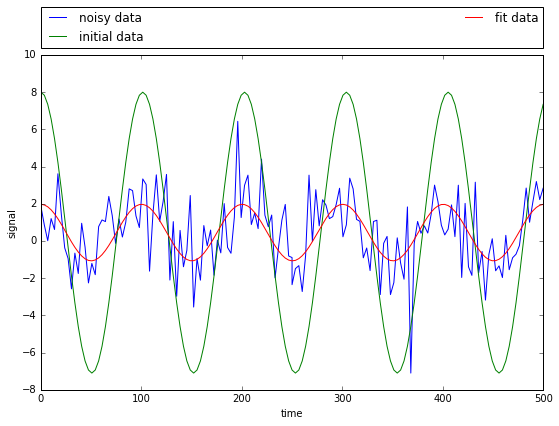

In [6]:
sine_testing2()